### Imports

In [1]:
#Base
import pandas as pd
import numpy as np

#others

import itertools
import string
import re

#Tensorflow
from tensorflow import keras

#Visuals
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#warnings
import warnings
warnings.filterwarnings('ignore')

2023-07-10 20:31:05.800701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [3]:
#nltk
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk import WordNetLemmatizer, pos_tag

### CSV File

In [4]:
df = pd.read_csv('/Users/kellyjara/Desktop/Project_4/Data/judge-1377884607_tweet_product_company.csv', 
                encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [7]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [8]:
tweet_1 = df['tweet_text'].iloc[0]
tweet_1

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [9]:
tweet_2 = df['tweet_text'].iloc[1]
tweet_2

"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW"

In [10]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [11]:
df.drop(columns = 'emotion_in_tweet_is_directed_at', inplace = True)

In [12]:
df.dropna(axis = 0, inplace = True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


In [14]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_tweet(tweet_text):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

         # rejoins lemmatized sentence 
    tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
    return tweet_norm

In [15]:
df['norm_tweets'] = df['tweet_text'].apply(process_tweet)

In [16]:
X = df['tweet_text']
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [22]:
ct_vec = CountVectorizer(min_df = 0.06, max_df = 0.95)
ct_vec.fit(X_train)

CountVectorizer(max_df=0.95, min_df=0.06)

In [24]:
X_tr_vec = ct_vec.transform(X_train)
X_te_vec = ct_vec.transform(X_test)

In [29]:
# Topic Modeling 
top_mod = NMF(n_components = 5)
top_mod.fit(X_tr_vec)

NMF(n_components=5)

In [32]:
# H weight of fitted topics
# W importance of each token in fitted topics

H = top_mod.transform(X_tr_vec)

W = top_mod.components_

print('Shape of W is' + str(W.shape))
print('Shape of H is ' + str(H.shape))
print('Shape of X_train is' + str(X_tr_vec.shape))

Shape of W is(5, 37)
Shape of H is (7273, 5)
Shape of X_train is(7273, 37)


In [35]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([ct_vec.get_feature_names_out()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['launch', 'austin', 'this', 'of', 'in', 'it', 'from', 'new', 'is', 'an', 'at', 'my', 'android', 'you', 'and', 'app', 'with', 'on', 'amp', 'ipad', 'iphone', 'for', 'link', 'rt', 'mention']


THE TOP 10 WORDS FOR TOPIC #1
['google', 'mention', 'link', 'amp', 'android', 'from', 'be', 'this', 'with', 'in', 'you', 'it', 'app', 'my', 'an', 'to', 'iphone', 'on', 'and', 'for', 'is', 'of', 'at', 'ipad', 'the']


THE TOP 10 WORDS FOR TOPIC #2
['in', 'amp', 'iphone', 'my', 'is', 'on', 'from', 'an', 'it', 'this', 'rt', 'with', 'of', 'you', 'be', 'and', 'today', 'launch', 'at', 'new', 'social', 'circles', 'link', 'google', 'to']


THE TOP 10 WORDS FOR TOPIC #3
['android', 'today', 'an', 'quot', 'with', 'of', 'this', 'amp', 'be', 'rt', 'launch', 'to', 'and', 'it', 'is', 'ipad', 'at', 'pop', 'austin', 'for', 'up', 'in', 'link', 'store', 'apple']


THE TOP 10 WORDS FOR TOPIC #4
['app', 'for', 'android', 'circles', 'from', 'mention', 'in', 'ipad', 'and', 'an', 'apple', 'r

In [36]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = ct_vec.get_feature_names_out()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

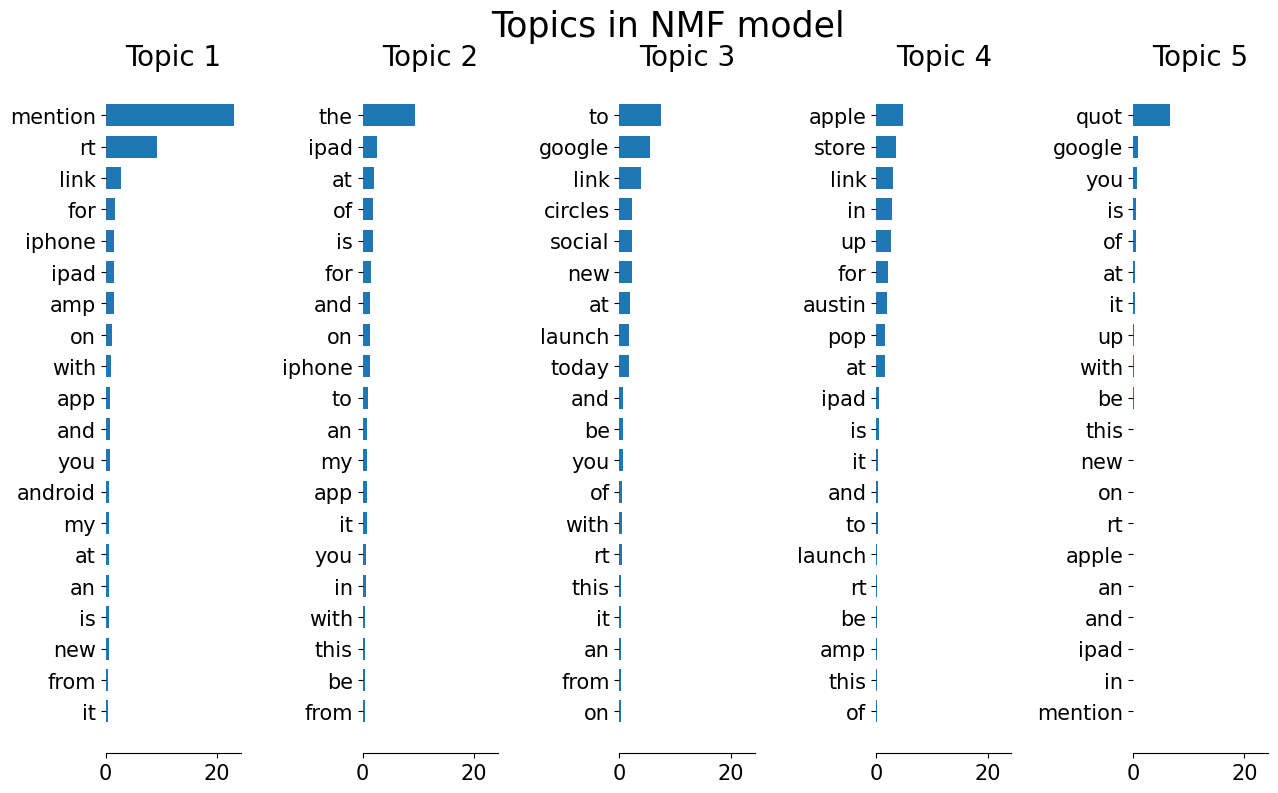

In [37]:
topic_word_plot()